In [24]:
import numpy as np
import torch
from diffusion import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
from diffusion.potential import LinearInterpolation, ZeroAlignedModel
from diffusion.utils import load_or_generate_and_then_save
from diffusion.train import train
import matplotlib.pyplot as plt

torch.random.manual_seed(199)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu' 
print(device)

cuda


Prepare a grid for plotting values.

In [2]:
ts = torch.linspace(0, 1, 50, dtype=torch.float32, device=device)
xs = torch.linspace(-3, 3, 50, dtype=torch.float32, device=device)

X, Y = torch.meshgrid(xs, ts, indexing='ij')

Define the prior and target potentials. The potential we train can either be a neural network that tries to match the SDE forces directly, or a linear interpolation between prior and target, with a network inbetween. In the later case, the network wil try to fit the entire potential to the SDE.

In [11]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)

def construct_net():
    return ZeroAlignedModel(torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 1)).to(device))

def construct_interpolation_potential():
    interpolating_model = construct_net()
    return LinearInterpolation(prior, target, interpolating_model)

Some functions that will come in handy for plotting...

In [4]:
def to_normalized_probabilities(energies):
    '''Computes a probability distribution from the input energies u(x,t), normalized 
    by time slice (so that sum_t p(x,t) = 1 for all t)'''
    probabilities = torch.exp(-energies)
    probabilities = probabilities / probabilities.sum(dim=0, keepdim=True)
    return probabilities

In [5]:
# The 'naive' way of linearly interpolating between our prior and target
naive_interpolation = lambda x, t :  (1-t) * target.energy(x) + (t) * prior.energy(x)


# Some functions that compute values for the naive interpolation potential
def compute_energies_naive(xs, ts):
    naive_out = naive_interpolation(xs, ts)
    return naive_out

def compute_probabilities_naive(xs, ts):
    naive_out = compute_energies_naive(xs, ts)
    return to_normalized_probabilities(naive_out.view(50,50))
 
def compute_forces_naive(xs, ts):
    xs_copy = xs.clone()
    xs_copy.requires_grad_(True)
    energies = compute_energies_naive(xs_copy, ts).sum()
    naive_forces = -torch.autograd.grad(energies, xs_copy)[0]
    return naive_forces

The data is sampled using MCMC and then saved. 

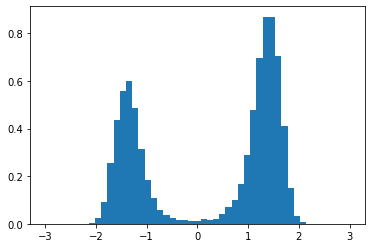

In [6]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))

datafilepath = './data/double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs.cpu(), density=True)
plt.stairs(counts, bins, fill=True)
plt.show()

In [7]:
def cumulative_beta_linear(t, alpha=1.):
    '''The integral of the noise schedule over the interval [0, t]. In this case a simple linear schedule'''
    return alpha * t

Below, the distribution of the diffusion are plotted, next to the probability distribution of the naively interpolated potential. The SDE allowd for earlier mixing of the data modes. 

/tmp/ipykernel_2332048/3618521038.py:15: UserWarning: The following kwargs were not used by contour: 'keepdim'
  im1=ax1.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))


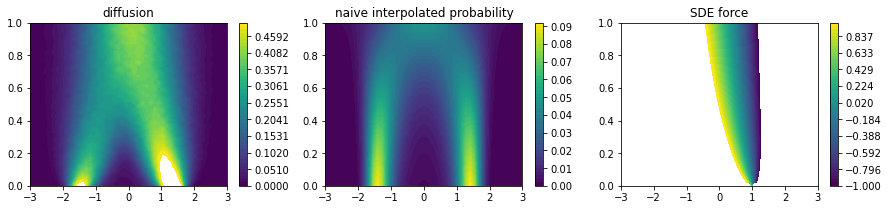

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

sde = SDE(TransitionKernel(cumulative_beta=lambda t: cumulative_beta_linear(t)))
# Show diffusion distribution of the data when propagating using the SDE
z = torch.zeros_like(X)
for i, t in enumerate(ts):
    t_s=torch.full_like(data, t)
    x_t = sde.forward_sample(x_0=data, t=t_s)
    z[:, i] = torch.histogram(x_t, bins=torch.cat([xs.cpu(), torch.tensor([6.])]), density=True)[0]


interpolation_probability = compute_probabilities_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1))

ax1.set_title('diffusion')
im1=ax1.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))
plt.colorbar(im1, ax=ax1)

ax2.set_title('naive interpolated probability')
im2=ax2.contourf(X.cpu(), Y.cpu(), interpolation_probability.cpu(), levels=50)
plt.colorbar(im2, ax=ax2)

ax3.set_title('SDE force')
sde_forces = sde.force(torch.ones_like(X).reshape(50,50, 1), X.reshape(50,50, 1), Y.reshape(50,50,1))
im3 = ax3.contourf(X.cpu(), Y.cpu(), sde_forces.cpu().view(50,50), levels=np.linspace(-1,1,50))
plt.colorbar(im3, ax=ax3)

Functions for constructing and training a model.

In [12]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

def MSE_loss(prediction, ground_truth):
    loss = ((prediction - ground_truth)**2).mean()
    return loss


def make_trained_model(variance_schedule_multiplier, dt_regularization_factor, use_interpolation=True, epochs=10):
    sde = SDE(TransitionKernel(cumulative_beta=lambda t: cumulative_beta_linear(t, variance_schedule_multiplier)))

    if use_interpolation:
        potential = construct_interpolation_potential()
    else:
        potential = construct_net()

    model = DiffusionModel(potential=potential, device=device, sde=sde)
    optimizer = Adam(model.parameters(), lr=1e-3)

    dt_loss = lambda dt : ((dt_regularization_factor * dt)**2).sum()

    train(model, 
        loss_fn_dx=MSE_loss,# torch.nn.functional.huber_loss, 
        loss_fn_dt=dt_loss,
        optimizer=optimizer, 
        data_loader=train_loader, 
        n_iterations=epochs,
        device=device)
    return model

In [13]:
model = make_trained_model(1., 0., use_interpolation=True, epochs=10)

Epoch 0/10 total loss: 3993.5029296875765380863
Epoch 1/10 total loss: 4157.1748046875598632866
Epoch 2/10 total loss: 3931.8034667968751767637
Epoch 3/10 total loss: 3897.817626953125397958
Epoch 4/10 total loss: 3712.3127441406252167363
Epoch 5/10 total loss: 3178.8603515625886474685
Epoch 6/10 total loss: 3006.3095703125275756846
Epoch 7/10 total loss: 2610.8198242187559594784
Epoch 8/10 total loss: 2221.8793945312564160165
Epoch 9/10 total loss: 1813.1138916015625105595


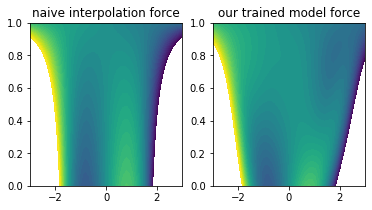

In [14]:
model_forces = model(X.reshape(50*50, 1).clone(), Y.reshape(50*50, 1).clone())[0].view(50,50).detach()
naive_forces = compute_forces_naive(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50, 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.set_title('naive interpolation force')
ax1.contourf(X.cpu(), Y.cpu(), naive_forces.cpu(), levels=np.linspace(-10,10,50))
ax2.set_title('our trained model force')
ax2.contourf(X.cpu(), Y.cpu(), model_forces.cpu(), levels=np.linspace(-10,10,50))

plt.show()

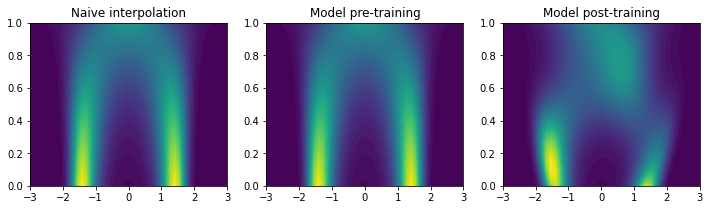

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))


# construct a new potential as an example of a pre-trained model
pre_training_energy = construct_interpolation_potential()(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
pre_training_probability = to_normalized_probabilities(pre_training_energy) 

model_energy = model.energy(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
model_probability = to_normalized_probabilities(model_energy) 


axes[0].set_title('Naive interpolation')
im1 = axes[0].contourf(X.cpu(), Y.cpu(), interpolation_probability.cpu(), levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)
axes[1].set_title('Model pre-training')
im2 = axes[1].contourf(X.cpu(), Y.cpu(), pre_training_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)
axes[2].set_title('Model post-training')
im3 = axes[2].contourf(X.cpu(), Y.cpu(), model_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))b
plt.colorbar(im3, ax=ax3)

The different terms that make up the potential are plotted below to see how the network actually contributes to the learned potential.

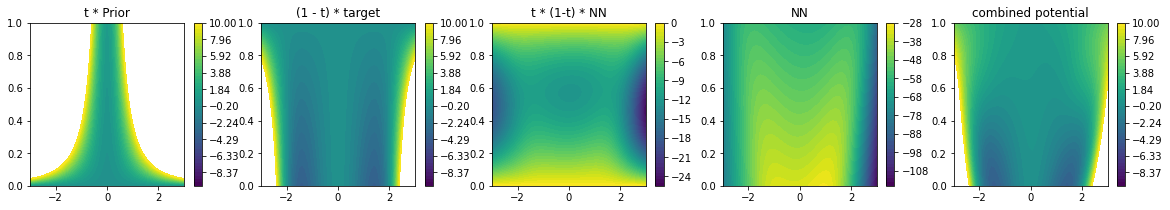

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

t_s = Y.reshape(50*50, 1)
ax1.set_title('t * Prior')
im1 = ax1.contourf(X.cpu(), Y.cpu(), Y.cpu() * prior.energy(X).cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im1, ax=ax1)

ax2.set_title('(1 - t) * target')
im2 = ax2.contourf(X.cpu(), Y.cpu(), (1-Y).cpu() * target.energy(X.reshape(50, 50, 1)).squeeze_().cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im2, ax=ax2)

ax3.set_title('t * (1-t) * NN')
im3 = ax3.contourf(X.cpu(), Y.cpu(), (Y * (1-Y) * model.potential.net(torch.hstack([X.reshape(50*50, 1), t_s])).view(50,50).detach()).cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im3, ax=ax3)

ax4.set_title('NN')
# ax4.contourf(X.cpu(), Y.cpu(), (Y * (1-Y)).cpu())
im4 = ax4.contourf(X.cpu(), Y.cpu(), model.potential.net(torch.hstack([X.reshape(50*50, 1), t_s])).view(50,50).detach().cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
plt.colorbar(im4, ax=ax4)

ax5.set_title('combined potential')
im5 = ax5.contourf(X.cpu(), Y.cpu(), model.energy(X.reshape(50*50, 1), t_s).view(50,50).detach().cpu(), levels=torch.linspace(-10,10, 50))
plt.colorbar(im5, ax=ax5)

The learned potential along different time slices

(-10.0, 20.0)

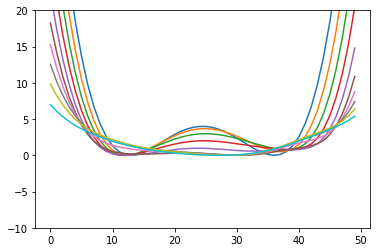

In [16]:
for t in np.arange(0, 50, 5):
    t_s = torch.full_like(xs, ts[t])
    u = model.energy(xs.unsqueeze(1), t_s.unsqueeze(1)).detach().cpu()
    plt.plot(u - u.min())
plt.ylim(-10,20)

Train a set of models using different parameters for comparison

In [ ]:
# ## different ways of combining the strength of the variance decay (first parameter, higher means earlier mixing) and time regularization (second parameter, higher is stronger regularization.)
# model_settings = [(1., 0.), (0.5, 0.), ( 2., 0.), (5., 0.), (0.5, 0.1), (2., 0.1), (5., 0.1)]
# models = []
# for (alpha, reg_factor) in model_settings:
#       models.append(make_trained_model(variance_schedule_multiplier=alpha, dt_regularization_factor=reg_factor, epochs=20))

Plot the potentials of the array of different trained models

In [ ]:
# fig, axes = plt.subplots(1, len(models), figsize=(3 * len(models), 3))

# for i, ((alpha, dt_reg), model) in enumerate(zip(model_settings, models)):
#     post_training_energy = model.energy(X.reshape(50*50, 1), Y.reshape(50*50, 1)).view(50,50).detach()
#     post_training_probability = to_normalized_probabilities(post_training_energy) 
#     axes[i].contourf(X.cpu(), Y.cpu(), post_training_probability.cpu(),levels=50)# levels=torch.linspace(-10,10, 50))
#     axes[i].set_title(f'a={alpha}, L={dt_reg}')

In [21]:
from math import sqrt


def langevin(force: callable, x_0: torch.tensor, tau: torch.FloatType):
    '''Do langevin dynamics of the potential from x_0 at t=1 to x_t at t=0 with timestep tau.
    (actually, start at t=1e-5 for stability reasons)'''
    t = 1
    x_t = x_0
    sqrt_tau = sqrt(tau)
    t_s = torch.full_like(x_t, t)
    while t > 1e-5:
        # x_t = x_t + tau * 0.5 * force.energy(x_t) + sqrt_tau * torch.rand_like(x_t)
        x_t = x_t + tau * 0.5 * force(x_t, t_s) + sqrt_tau * torch.randn_like(x_t)
        t_s = t_s - tau
        t -= tau
    return x_t


x_0 = torch.randn((10000, 1)).to(device)
x_t = langevin(model.force, x_0, 0.001)

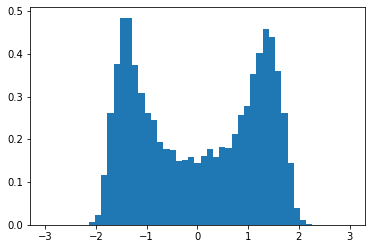

In [22]:
# plot histogram of the sampled data
counts, bins = np.histogram(x_t.detach().cpu(), bins=xs.cpu(), density=True)
plt.stairs(counts, bins, fill=True)
plt.show()